In [21]:
import numpy  as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet18
import torch
import torchvision.transforms as transforms
import seaborn as sns
import torch.optim as optim
from torch.utils.data import RandomSampler
import torchvision.models as models
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

import os
import shutil

from tabulate import tabulate
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F



In [3]:
device = 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else device)

print("Device: ", device)

Device:  cuda:0


In [4]:
data_path_train = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize to 224 x 224 x 3
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

training_data = datasets.ImageFolder(root = data_path_train, transform = transform)

total_size = len(training_data)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(training_data, [train_size, val_size, test_size], generator = torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_data, batch_size = 128, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = False, num_workers = 4)

print("Train Size: ", len(train_data))
print("Val Size: ", len(val_data))
print("Test Size: ", len(test_data))

#class info
class_names = training_data.classes
num_classes = len(class_names)

print("Data classes:")
print(class_names)
print(num_classes)


Train Size:  60899
Val Size:  13050
Test Size:  13051
Data classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
29


In [6]:
model = models.resnet18(pretrained = True)

# Define a function to count parameters
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

# Initialize table data
table_data = []

# Dummy input with 3 channels (for RGB image)
dummy_input = torch.randn(1, 3, 224, 224)

# Iterate through model's children
for name, layer in model.named_children():
    # For convolutional layers, use dummy input to infer shapes
    if isinstance(layer, torch.nn.Conv2d):
        output_shape = tuple(layer(dummy_input).shape[1:])
    else:
        # For other layers, just use dummy input shape
        output_shape = tuple(dummy_input.shape[1:])

    # Get number of parameters
    num_params = count_parameters(layer)

    # Append layer information to table data
    table_data.append([name, str(layer.__class__.__name__), output_shape, num_params[0], num_params[1]])

# Print table
print(tabulate(table_data, headers=["Layer Name", "Layer Type", "Output Shape", "Trainable Params", "Non-trainable Params"]))

# Print total trainable and non-trainable params
total_trainable_params, total_non_trainable_params = count_parameters(model)
print("\nTotal Trainable Parameters:", total_trainable_params)
print("Total Non-trainable Parameters:", total_non_trainable_params)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Layer Name    Layer Type         Output Shape      Trainable Params    Non-trainable Params
------------  -----------------  --------------  ------------------  ----------------------
conv1         Conv2d             (64, 112, 112)                9408                       0
bn1           BatchNorm2d        (3, 224, 224)                  128                       0
relu          ReLU               (3, 224, 224)                    0                       0
maxpool       MaxPool2d          (3, 224, 224)                    0                       0
layer1        Sequential         (3, 224, 224)               147968                       0
layer2        Sequential         (3, 224, 224)               525568                       0
layer3        Sequential         (3, 224, 224)              2099712                       0
layer4        Sequential         (3, 224, 224)              8393728                       0
avgpool       AdaptiveAvgPool2d  (3, 224, 224)                    0             

In [7]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
# find, ResNet::forward, self.fc

num_classes = num_classes
model = resnet18(pretrained = True)
model = nn.DataParallel(model)
model.module.fc = nn.Linear(model.module.fc.in_features, num_classes)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

print(f"Device: {device}")
print(f"Model: {model}")

Device: cuda:0
Model: DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [8]:
def training(loss_func, optimizer):
    total_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_func(outputs, labels)

        loss.backward()

        optimizer.step()

        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    return total_loss, correct_train, total_train


def validation(loss_func):

    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_loss = loss_func(outputs, labels)
            total_val_loss += val_loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    #average validation loss
    val_loss = total_val_loss / len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    return val_loss, val_accuracy

In [9]:
# freeze all layers but the fc (fully connected) layer (classifier output layer)
for param in model.parameters(): 
    param.requires_grad = False
for param in model.module.fc.parameters():
    param.requires_grad = True

# print which weights can be trained
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: module.conv1.weight, Requires Gradient: False
Layer: module.bn1.weight, Requires Gradient: False
Layer: module.bn1.bias, Requires Gradient: False
Layer: module.layer1.0.conv1.weight, Requires Gradient: False
Layer: module.layer1.0.bn1.weight, Requires Gradient: False
Layer: module.layer1.0.bn1.bias, Requires Gradient: False
Layer: module.layer1.0.conv2.weight, Requires Gradient: False
Layer: module.layer1.0.bn2.weight, Requires Gradient: False
Layer: module.layer1.0.bn2.bias, Requires Gradient: False
Layer: module.layer1.1.conv1.weight, Requires Gradient: False
Layer: module.layer1.1.bn1.weight, Requires Gradient: False
Layer: module.layer1.1.bn1.bias, Requires Gradient: False
Layer: module.layer1.1.conv2.weight, Requires Gradient: False
Layer: module.layer1.1.bn2.weight, Requires Gradient: False
Layer: module.layer1.1.bn2.bias, Requires Gradient: False
Layer: module.layer2.0.conv1.weight, Requires Gradient: False
Layer: module.layer2.0.bn1.weight, Requires Gradient: False
Layer

In [10]:
print("Stage 1: Freezing all layers EXCEPT for Fully Connected")


learning_rate_s1 = 0.01
loss_func = nn.CrossEntropyLoss()

num_epochs = 10

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

optimizer = optim.SGD(model.parameters(), lr = learning_rate_s1)

for epoch in range(num_epochs):
    # training
    model.train()
    total_loss, correct_train, total_train = training(loss_func, optimizer)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation
    model.eval()
    val_loss, val_accuracy = validation(loss_func)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Training Loss: {epoch_train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Stage 1: Freezing all layers EXCEPT for Fully Connected
Epoch 1: Training Loss: 2.5477585069718103, Training Accuracy: 0.41521207244782343, Validation Loss: 1.9411044286494055, Validation Accuracy: 0.6318007662835249
Epoch 2: Training Loss: 1.6783745154643244, Training Accuracy: 0.6800604279216408, Validation Loss: 1.440886411776488, Validation Accuracy: 0.7324137931034482
Epoch 3: Training Loss: 1.3297679661396864, Training Accuracy: 0.7402748813609419, Validation Loss: 1.18704699487065, Validation Accuracy: 0.7705747126436782
Epoch 4: Training Loss: 1.1396266180422998, Training Accuracy: 0.7679436443948177, Validation Loss: 1.0336792066727563, Validation Accuracy: 0.794712643678161
Epoch 5: Training Loss: 1.0138853722016885, Training Accuracy: 0.7890605757073187, Validation Loss: 0.9358331445533197, Validation Accuracy: 0.8057471264367816
Epoch 6: Training Loss: 0.9299870429509739, Training Accuracy: 0.8009983743575428, Validation Loss: 0.8651105194530267, Validation Accuracy: 0.8158

In [11]:
# unfreeze all layers but fc layer and reduce learning rate
for param in model.parameters(): 
    param.requires_grad = True
for param in model.module.fc.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: module.conv1.weight, Requires Gradient: True
Layer: module.bn1.weight, Requires Gradient: True
Layer: module.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.bias, Requires Gradient: True
Layer: module.layer1.1.conv1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.bias, Requires Gradient: True
Layer: module.layer1.1.conv2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.bias, Requires Gradient: True
Layer: module.layer2.0.conv1.weight, Requires Gradient: True
Layer: module.layer2.0.bn1.weight, Requires Gradient: True
Layer: module.layer2.0

In [12]:
print("Stage 2: Freezing Fully Connected Layers and Unfreezing Other Layers and Reducing Learning Rate")
learning_rate_s2 = 0.001
optimizer = optim.SGD(model.parameters(), lr = learning_rate_s2)

for epoch in range(num_epochs):
    # training
    model.train()
    total_loss, correct_train, total_train = training(loss_func, optimizer)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation
    model.eval()
    val_loss, val_accuracy = validation(loss_func)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Training Loss: {epoch_train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Stage 2: Freezing Fully Connected Layers and Unfreezing Other Layers and Reducing Learning Rate
Epoch 1: Training Loss: 0.30908975898646945, Training Accuracy: 0.9312796597645282, Validation Loss: 0.17132376323714568, Validation Accuracy: 0.9659770114942529
Epoch 2: Training Loss: 0.1457123277760364, Training Accuracy: 0.9712310546971215, Validation Loss: 0.10342430688183883, Validation Accuracy: 0.9805363984674329
Epoch 3: Training Loss: 0.10041132555720717, Training Accuracy: 0.9822164567562686, Validation Loss: 0.07354858772622215, Validation Accuracy: 0.988735632183908
Epoch 4: Training Loss: 0.07637123115362328, Training Accuracy: 0.9882264076585823, Validation Loss: 0.056654849211146545, Validation Accuracy: 0.9924904214559387
Epoch 5: Training Loss: 0.06230227443760891, Training Accuracy: 0.9909029704921263, Validation Loss: 0.04962460336671479, Validation Accuracy: 0.9921072796934866
Epoch 6: Training Loss: 0.052859231789025296, Training Accuracy: 0.9923644066405032, Validation

In [13]:
# unfreeze all layers and reduce learning rate
for param in model.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

Layer: module.conv1.weight, Requires Gradient: True
Layer: module.bn1.weight, Requires Gradient: True
Layer: module.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.weight, Requires Gradient: True
Layer: module.layer1.0.bn1.bias, Requires Gradient: True
Layer: module.layer1.0.conv2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.weight, Requires Gradient: True
Layer: module.layer1.0.bn2.bias, Requires Gradient: True
Layer: module.layer1.1.conv1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.weight, Requires Gradient: True
Layer: module.layer1.1.bn1.bias, Requires Gradient: True
Layer: module.layer1.1.conv2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.weight, Requires Gradient: True
Layer: module.layer1.1.bn2.bias, Requires Gradient: True
Layer: module.layer2.0.conv1.weight, Requires Gradient: True
Layer: module.layer2.0.bn1.weight, Requires Gradient: True
Layer: module.layer2.0

In [14]:
print("Stage 3: Unfreezing All Layers and Reducing Learning Rate")

learning_rate_s3 = 0.0001
optimizer = optim.SGD(model.parameters(), lr = learning_rate_s3)

for epoch in range(num_epochs):
    # training
    model.train()
    total_loss, correct_train, total_train = training(loss_func, optimizer)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # validation
    model.eval()
    val_loss, val_accuracy = validation(loss_func)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}: Training Loss: {epoch_train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

Stage 3: Unfreezing All Layers and Reducing Learning Rate
Epoch 1: Training Loss: 0.029813496596557867, Training Accuracy: 0.9967158738238723, Validation Loss: 0.024195649029251715, Validation Accuracy: 0.9972413793103448
Epoch 2: Training Loss: 0.02949611845950854, Training Accuracy: 0.9963546199444983, Validation Loss: 0.02511504452290206, Validation Accuracy: 0.9974712643678161
Epoch 3: Training Loss: 0.02910827708411518, Training Accuracy: 0.996502405622424, Validation Loss: 0.024668262019981825, Validation Accuracy: 0.9972413793103448
Epoch 4: Training Loss: 0.028825315238613727, Training Accuracy: 0.9968308182400368, Validation Loss: 0.02485611308722889, Validation Accuracy: 0.9973180076628353
Epoch 5: Training Loss: 0.028619455614964855, Training Accuracy: 0.9965680881459466, Validation Loss: 0.023354045160942607, Validation Accuracy: 0.9978544061302682
Epoch 6: Training Loss: 0.027939212143503877, Training Accuracy: 0.9969293420253206, Validation Loss: 0.022991093483921213, Val

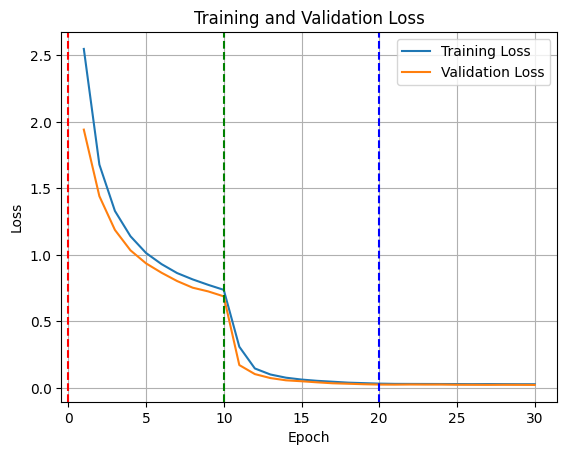

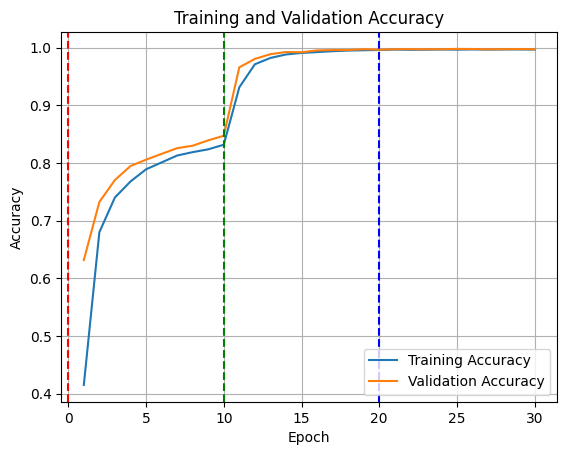

In [15]:
epochs = np.arange(1, 31)

#loss curves
plt.figure()
plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

#indicate where layers were frozen/unfrozen and where learning rate was changed
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=10, color='g', linestyle='--')
plt.axvline(x=20, color='b', linestyle='--')
plt.show()

#accuracy curves
plt.figure()
plt.plot(epochs, train_accuracies, label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

#indicate where layers were frozen/unfrozen and where learning rate was changed
plt.axvline(x=0, color='r', linestyle='--')
plt.axvline(x=10, color='g', linestyle='--')
plt.axvline(x=20, color='b', linestyle='--')


In [16]:
model.eval()

new_predictions = []
new_labels = []
incorrect_indices = []
misclassified_images = []
misclassified_preds = []
misclassified_trues = []

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        new_predictions.extend(predictions.cpu().numpy())
        new_labels.extend(labels.cpu().numpy())

        for i, (pred, true) in enumerate(zip(predictions, labels)):
            if pred != true:
                global_index = batch_idx * test_loader.batch_size + i
                incorrect_indices.append(global_index)

                misclassified_images.append(images[i].cpu())  # store original image
                misclassified_preds.append(pred.item())
                misclassified_trues.append(true.item())

new_accuracy = accuracy_score(new_labels, new_predictions)

print("Number of Incorrect Classifications:", len(incorrect_indices))
print("Incorrect Indices:", incorrect_indices)
print("Testing Set Accuracy after Fine-Tuning ResNet18:", new_accuracy)


Number of Incorrect Classifications: 37
Incorrect Indices: [206, 440, 645, 1046, 1356, 2324, 2993, 3414, 3504, 3756, 3990, 4729, 5126, 5436, 6342, 6414, 6492, 6976, 7511, 7548, 7751, 7785, 8144, 8448, 8567, 8994, 9022, 9732, 9880, 10781, 10999, 11862, 12084, 12528, 12555, 12598, 12715]
Testing Set Accuracy after Fine-Tuning ResNet18: 0.9971649682016703


In [17]:
# print(new_labels)
print("Unique predictions:", sorted(set(new_predictions)))


Unique predictions: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


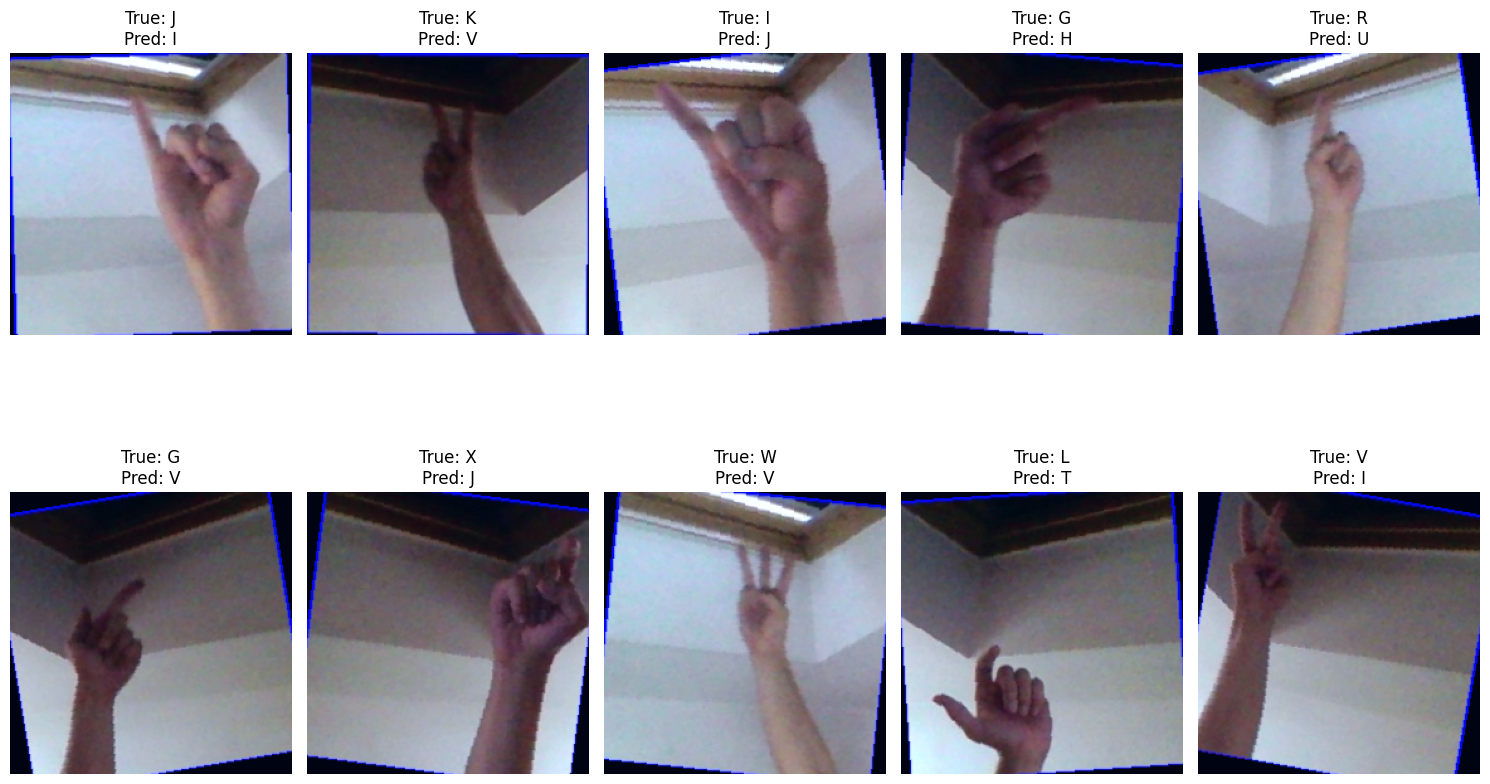

In [18]:
num_display = min(10, len(misclassified_images))

plt.figure(figsize=(15, 10))
for idx in range(num_display):
    image = misclassified_images[idx]
    true_label = misclassified_trues[idx]
    pred_label = misclassified_preds[idx]

    plt.subplot(2, 5, idx + 1)
    img_np = image.permute(1, 2, 0).numpy()
    img_np = (img_np * 0.229 + 0.485)
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


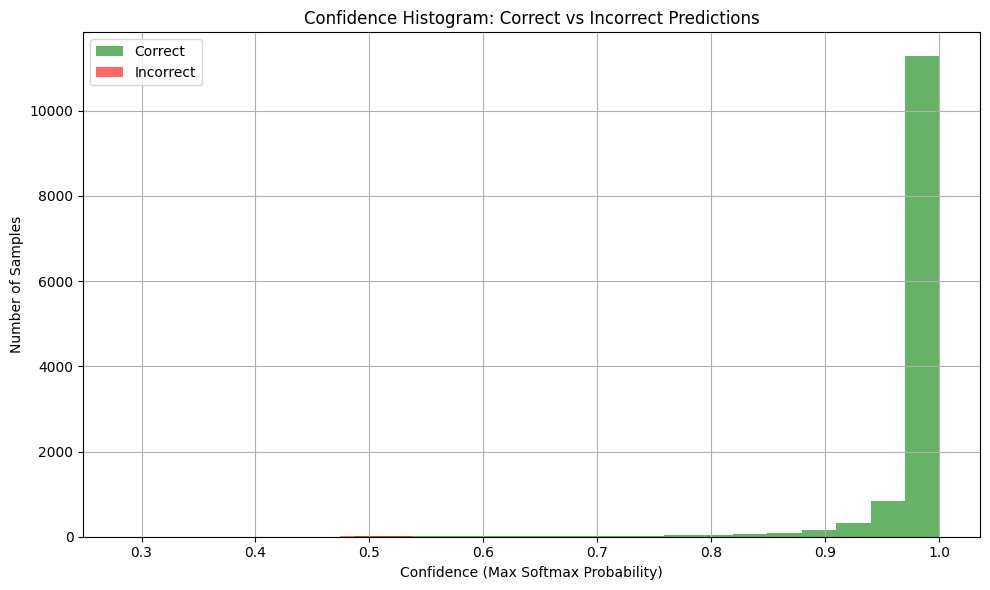

In [22]:
correct_confidences = []
incorrect_confidences = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim = 1)
        confidences, predictions = torch.max(probs, dim = 1)

        for conf, pred, true in zip(confidences, predictions, labels):
            if pred == true:
                correct_confidences.append(conf.item())
            else:
                incorrect_confidences.append(conf.item())

# histogram
plt.figure(figsize = (10, 6))
plt.hist(correct_confidences, bins = 20, alpha = 0.6, label = 'Correct', color = 'green')
plt.hist(incorrect_confidences, bins = 20, alpha = 0.6, label = 'Incorrect', color = 'red')
plt.xlabel('Confidence (Max Softmax Probability)')
plt.ylabel('Number of Samples')
plt.title('Confidence Histogram: Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


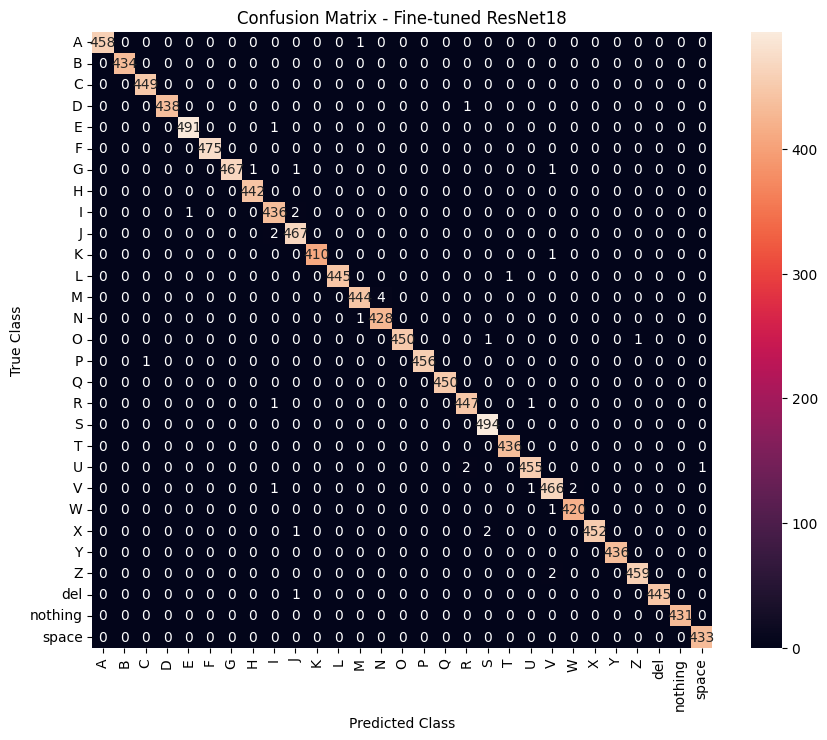

In [19]:
fine_tuned_conf_matrix = confusion_matrix(new_labels, new_predictions)

class_names = class_names

plt.figure(figsize = (10, 8))
sns.heatmap(fine_tuned_conf_matrix, annot = True, fmt = "d", xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix - Fine-tuned ResNet18")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

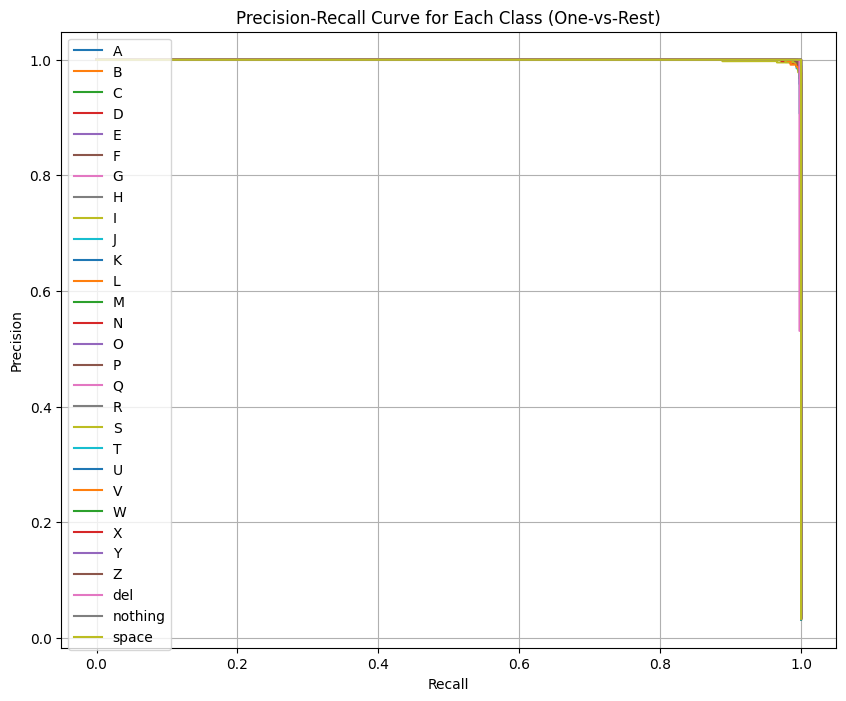

In [20]:
model.eval()

all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

predicted_probs = np.concatenate(all_probs)

binarized_labels = label_binarize(new_labels, classes = np.unique(new_labels))

precisions = dict()
recalls = dict()
for i in range(num_classes):
    precisions[i], recalls[i], _ = precision_recall_curve(binarized_labels[:, i], predicted_probs[:, i])

class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(recalls[i], precisions[i])
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class (One-vs-Rest)')
plt.legend(class_labels)
plt.grid(True)
plt.show()
